# Seleção de Atributos (MATEMÁTICA)
Objetivo: Avaliar os atributos mais relevantes para o desempenho acadêmico utilizando testes estatísticos e regressões com base nos módulos existentes.

###### ajustar o path

In [68]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

## Importações e Configurações Iniciais

In [69]:
#Importação dos módulos desenvolvidos

from pre_modelagem import *
from eda_functions import *
from feature_selection import *

# Bibliotecas

import pandas as pd
import numpy as np



from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
import shap



import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [70]:
#Import base

materia =  'matematica' 
#materia = 'portugues'
cor_paleta = 'verde' 
#cor_paleta = 'azul'
df = importar_base(materia)

df_original = df.copy() 

# 2. Síntese dos resultados EDA


 - As notas apresentaram distribuições não normais segundo Shapiro-Wilk
 - Algumas variáveis categóricas demonstraram associação com aprovação
 - Multicolinearidade ainda será avaliada neste notebook


## 3. Avaliação de multicolinearidade
- Análise de VIF e correlação para identificar redundâncias entre as variáveis.

In [71]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'])

Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (395, 42)


In [72]:
# Remove variáveis-alvo antes da análise de VIF/correlação entre preditores
variaveis_target = ['nota1', 'nota2', 'nota_final']
df_preditores = df_pp.drop(columns=variaveis_target)


print('limiar coeficiente de correlação > 0.6')
resumo, vif_df =  relatorio_multicolinearidade(df_preditores,limite_corr=0.6)
    
display(resumo[resumo['avaliacao'] != 'Sem alerta'])


limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.623455
189,alcool_fim_semana,alcool_dias_uteis,0.647544
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.690275


,variavel,vif,Alta correlação com,avaliacao
0,idade,82.139473,—,VIF elevado
15,relacao_familiar,23.051333,—,VIF elevado
12,interesse_ensino_superior,22.819368,—,VIF elevado
2,escolaridade_mae,21.314427,escolaridade_pai,VIF alto + correlação alta
16,tempo_livre,14.422785,—,VIF elevado
3,escolaridade_pai,13.504657,escolaridade_mae,VIF alto + correlação alta
17,frequencia_saidas,12.715131,—,VIF elevado
30,profissao_pai_Outra profissão,12.622123,profissao_pai_Serviços,VIF alto + correlação alta
19,alcool_fim_semana,9.922161,alcool_dias_uteis,VIF alto + correlação alta
5,tempo_estudo,9.357646,—,VIF elevado


In [73]:
variaveis_alta_colineariedade = [
            #'escolaridade_mae',
            'escolaridade_pai',
            'alcool_fim_semana',
            'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [74]:
corr = df_pp[variaveis_alta_colineariedade + variaveis_target].corr()

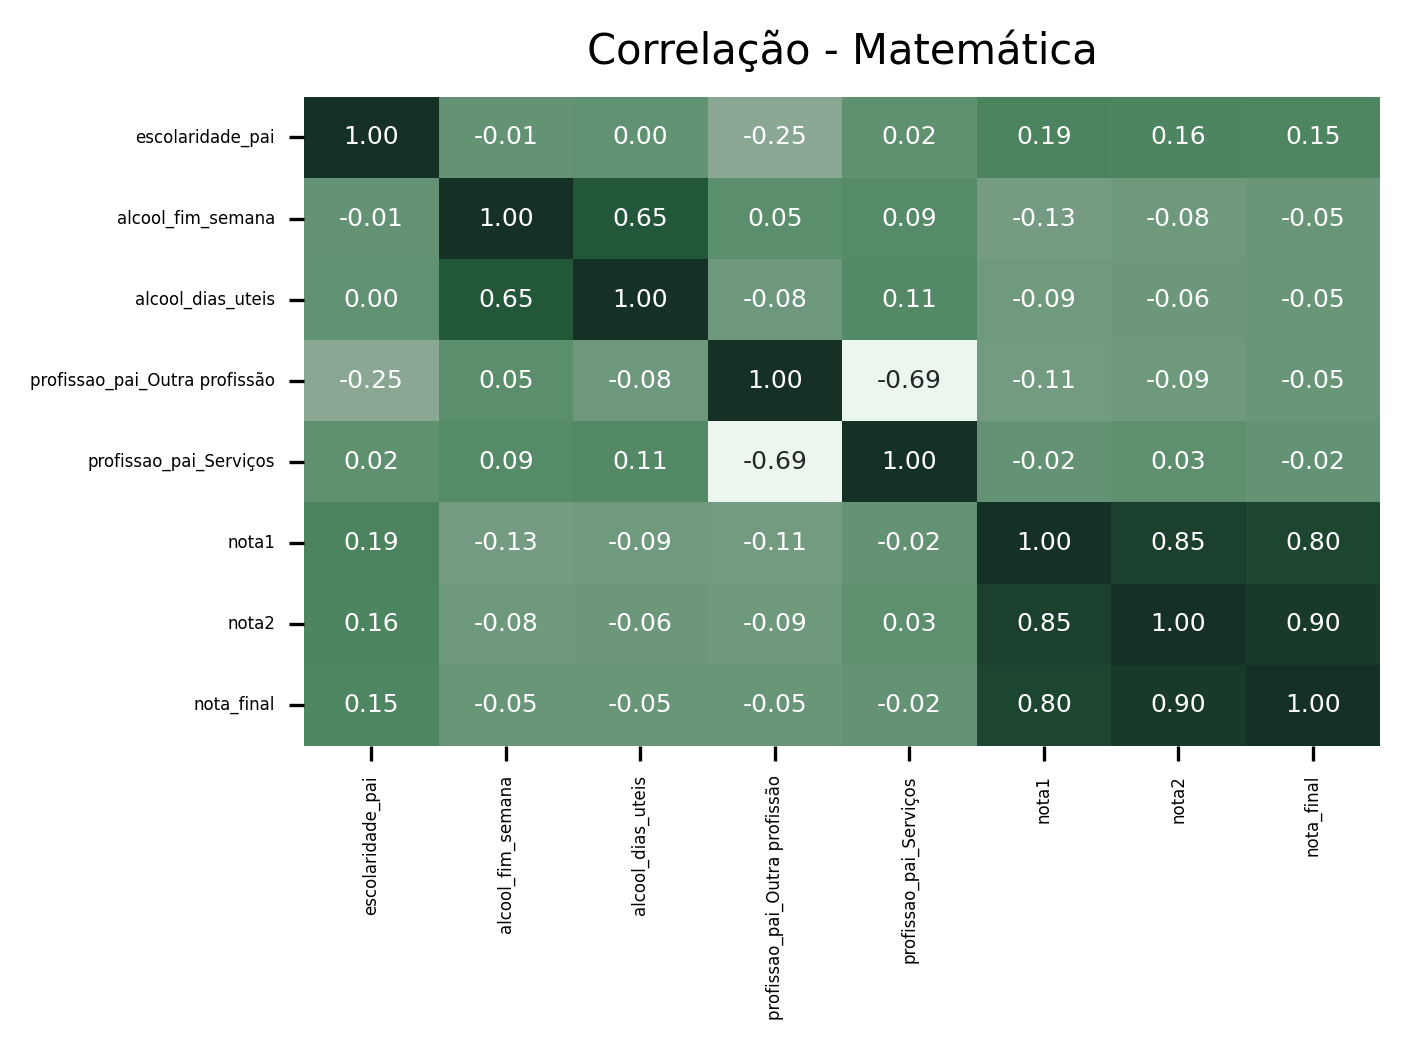

In [75]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

# 4. Análise da Relação entre Nota 1 e Nota 2

**REGRESSÃO NOTAS**


## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

In [76]:
#Pré processamento

df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota_final'],target_column='nota2')

Removendo colunas: ['aprovacao', 'nota_final']
Shape final do DataFrame preparado: (395, 41)


In [77]:
modelo_n2_1 = regressao_multipla(df_pp, target='nota2', variaveis=['nota1'])

print(modelo_n2_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1042.
Date:                Sat, 10 May 2025   Prob (F-statistic):          1.44e-112
Time:                        03:40:58   Log-Likelihood:                -827.52
No. Observations:                 395   AIC:                             1659.
Df Residuals:                     393   BIC:                             1667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1796      0.341      0.526      0.5

## 4.2. Regressão múltipla com nota1 e variáveis adicionais
- Objetivo: Avaliar estabilidade dos coeficientes da nota1 e identificar covariáveis explicativas para nota2.

**Regressão sem selecao de atributos**

In [78]:
aux_drop = ['nota2']

variaveis_1 = list(set(df_pp.columns) - set(aux_drop))

modelo_n2_2 = regressao_multipla(df_pp, target='nota2',variaveis=variaveis_1)

**Identificando os menores pvalores do sumário** 

In [79]:
_ , top_15_var = ajustar_regressao(
                                df=df_pp,
                                target_column='nota2',
                                top_n =15    
                              )   

--- Sumário do Modelo de Regressão OLS ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     30.17
Date:                Sat, 10 May 2025   Prob (F-statistic):           8.22e-91
Time:                        03:40:58   Log-Likelihood:                -790.25
No. Observations:                 395   AIC:                             1663.
Df Residuals:                     354   BIC:                             1826.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

,Coef.,Std.Err.,t,P>|t|
nota1,0.961,0.035,27.351,2.60e-89
relacionamento_romantico,-0.614,0.216,-2.845,0.005
tempo_transporte,-0.323,0.156,-2.073,0.039
profissao_pai_Serviços,1.002,0.488,2.054,0.041
apoio_escolar,0.609,0.316,1.928,0.055
motivo_escolha_escola_Outro motivo,0.700,0.376,1.862,0.063
aulas_particulares,0.394,0.220,1.794,0.074
profissao_pai_Outra profissão,0.755,0.472,1.598,0.111
frequencia_saidas,-0.154,0.104,-1.472,0.142
relacao_familiar,-0.161,0.113,-1.421,0.156


-----------------------------------------------

Atributos de maior relevância (por P-valor):
1. nota1
2. relacionamento_romantico
3. tempo_transporte
4. profissao_pai_Serviços
5. apoio_escolar
6. motivo_escolha_escola_Outro motivo
7. aulas_particulares
8. profissao_pai_Outra profissão
9. frequencia_saidas
10. relacao_familiar
11. escolaridade_mae
12. profissao_mae_Outra profissão
13. acesso_internet
14. idade
15. status_parental_Separados


In [80]:
top_15_var

['nota1',
 'relacionamento_romantico',
 'tempo_transporte',
 'profissao_pai_Serviços',
 'apoio_escolar',
 'motivo_escolha_escola_Outro motivo',
 'aulas_particulares',
 'profissao_pai_Outra profissão',
 'frequencia_saidas',
 'relacao_familiar',
 'escolaridade_mae',
 'profissao_mae_Outra profissão',
 'acesso_internet',
 'idade',
 'status_parental_Separados']

In [81]:
aux = ['nota2']

variaveis_1 = top_15_var

modelo_n2_3 = regressao_multipla(df_pp[variaveis_1 + aux], 
                                 target='nota2',variaveis=variaveis_1)


**extraindo atributos com multicolineariedade elevada**

In [82]:
aux = list(set(top_15_var) & set(variaveis_alta_colineariedade))
aux

['profissao_pai_Outra profissão', 'profissao_pai_Serviços']

In [83]:
aux_drop = ['nota2','profissao_pai_Outra profissão']

variaveis_1 = list(set(top_15_var) - set(aux_drop))

modelo_n2_4 = regressao_multipla(df_pp[variaveis_1+['nota2']],
                               target='nota2', variaveis=variaveis_1)


In [84]:
aux_drop = ['nota2','profissao_pai_Outra profissão']

variaveis_1 = list(set(top_15_var) - set(aux_drop))
#incluindo faltas
modelo_n2_5 = regressao_multipla(df_pp[variaveis_1+['nota2','faltas']],
                               target='nota2', variaveis=variaveis_1)

**stepwise_selection** - AIC e BIC

In [85]:
variaveis_sem_nota = df_pp.drop(columns='nota2').columns


features_bic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', 
    verbose=True 
)

features_aic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='bic', # Escolhendo BIC
    verbose=True 
)


from itertools import chain

seen = set()
features_all = []    
for item in chain(*[features_aic,features_bic]):
    if item not in seen:
        seen.add(item)
        features_all.append(item)

features_all

Critério inicial (AIC): 2168.5672
Adicionada: nota1 (AIC=1659.0378)
Adicionada: idade (AIC=1649.4323)
Adicionada: aulas_particulares (AIC=1644.2960)
Adicionada: relacionamento_romantico (AIC=1639.3631)
Adicionada: tempo_transporte (AIC=1635.0297)
Adicionada: motivo_escolha_escola_Outro motivo (AIC=1632.7932)
Adicionada: profissao_mae_Outra profissão (AIC=1630.5062)
Adicionada: profissao_pai_Serviços (AIC=1628.4618)
Adicionada: profissao_pai_Outra profissão (AIC=1626.9052)
Adicionada: apoio_escolar (AIC=1625.0409)
Adicionada: relacao_familiar (AIC=1623.4490)
Adicionada: acesso_internet (AIC=1622.7099)
Adicionada: status_parental_Separados (AIC=1622.3926)

Variáveis selecionadas final (aic): ['nota1', 'idade', 'aulas_particulares', 'relacionamento_romantico', 'tempo_transporte', 'motivo_escolha_escola_Outro motivo', 'profissao_mae_Outra profissão', 'profissao_pai_Serviços', 'profissao_pai_Outra profissão', 'apoio_escolar', 'relacao_familiar', 'acesso_internet', 'status_parental_Separados

['nota1',
 'idade',
 'aulas_particulares',
 'relacionamento_romantico',
 'tempo_transporte',
 'motivo_escolha_escola_Outro motivo',
 'profissao_mae_Outra profissão',
 'profissao_pai_Serviços',
 'profissao_pai_Outra profissão',
 'apoio_escolar',
 'relacao_familiar',
 'acesso_internet',
 'status_parental_Separados']

In [86]:
modelo_step = regressao_multipla(df_pp[features_all+['nota2']],target='nota2', variaveis=features_all)
print(modelo_step.summary())

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     95.45
Date:                Sat, 10 May 2025   Prob (F-statistic):          4.39e-111
Time:                        03:41:00   Log-Likelihood:                -797.20
No. Observations:                 395   AIC:                             1622.
Df Residuals:                     381   BIC:                             1678.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## 4.3 Importância dos atributos com SHAP (Random Forest Regressor)


In [87]:
comparar_modelos_regressao(
    modelos=[modelo_n2_1, modelo_n2_2, modelo_n2_3, modelo_n2_4, modelo_n2_5, modelo_step],
    nomes=['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo Step']
)

,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Variáveis Significantes
0,Modelo 1,0.726105,0.725408,1659.037807,1666.995579,-827.518904,1041.857466,1.971085,1
1,Modelo 2,0.773205,0.747578,1662.502959,1825.637276,-790.251480,30.171956,1.889841,4
2,Modelo 3,0.766548,0.757309,1623.929369,1687.591541,-795.964685,82.964069,1.853057,9
3,Modelo 4,0.762884,0.754148,1628.081471,1687.764757,-799.040735,87.327782,1.865085,7
4,Modelo 5,0.762884,0.754148,1628.081471,1687.764757,-799.040735,87.327782,1.865085,7
5,Modelo Step,0.765088,0.757072,1622.392573,1678.096973,-797.196286,95.452501,1.853959,10


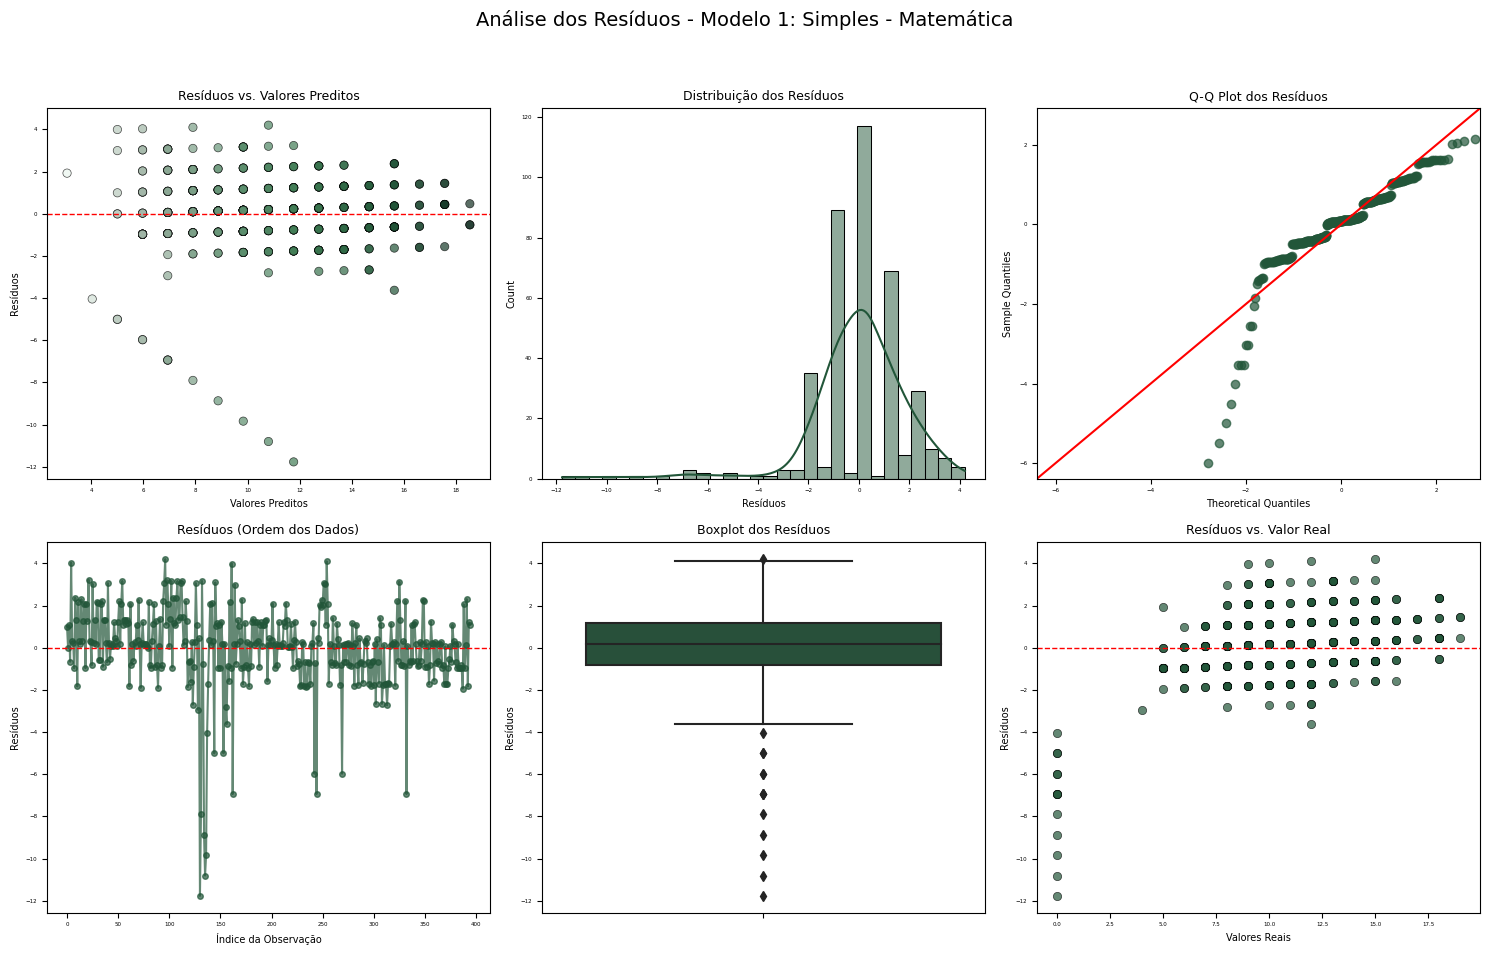

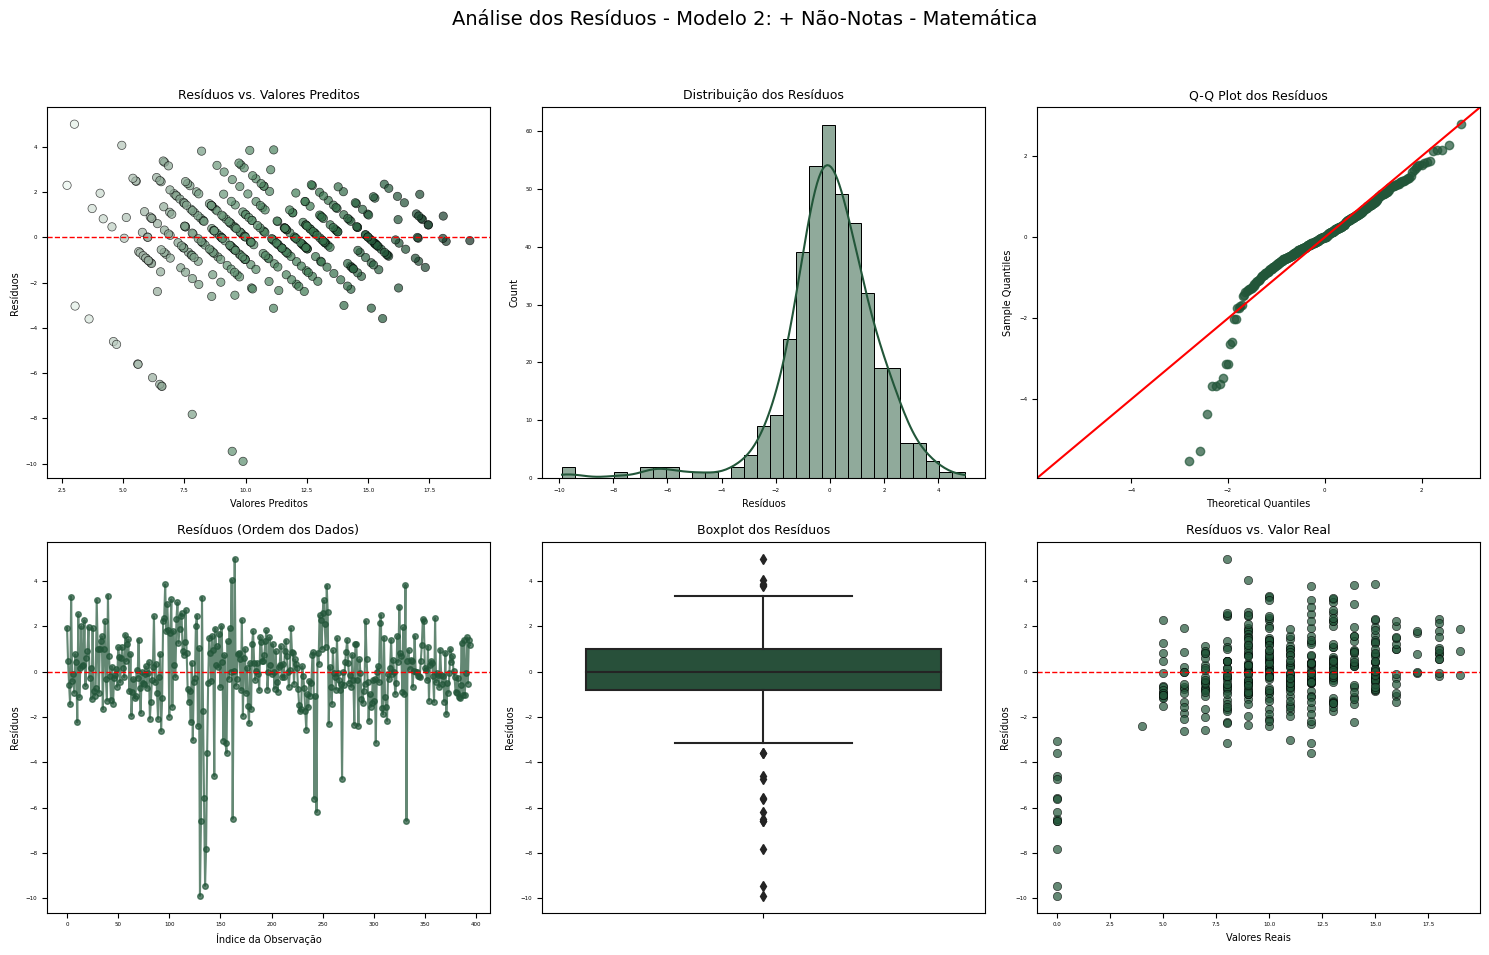

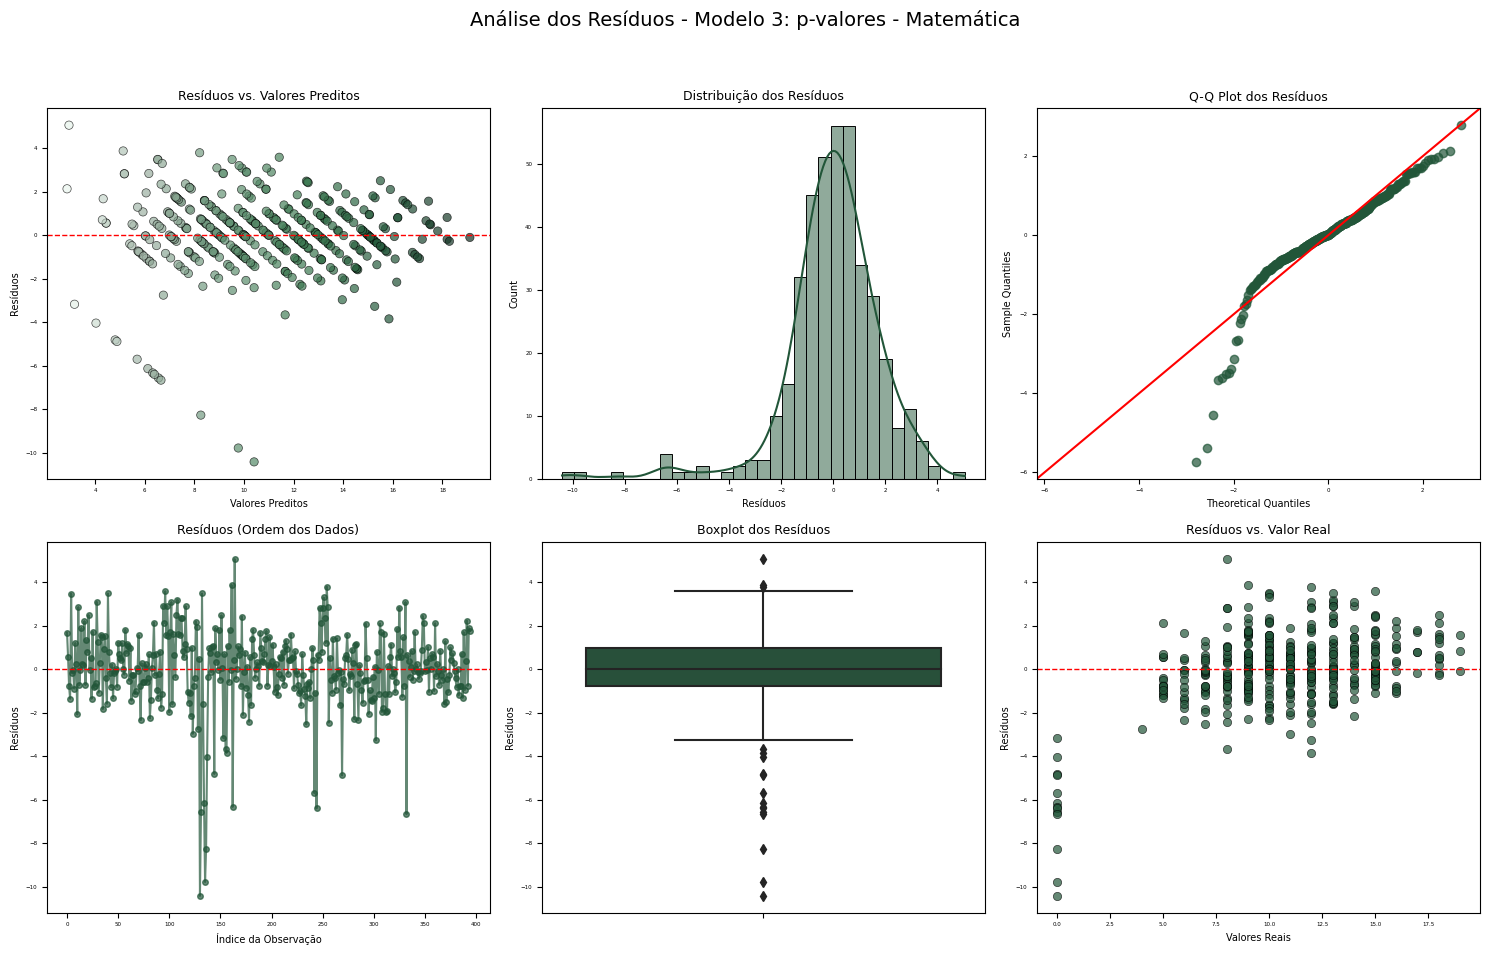

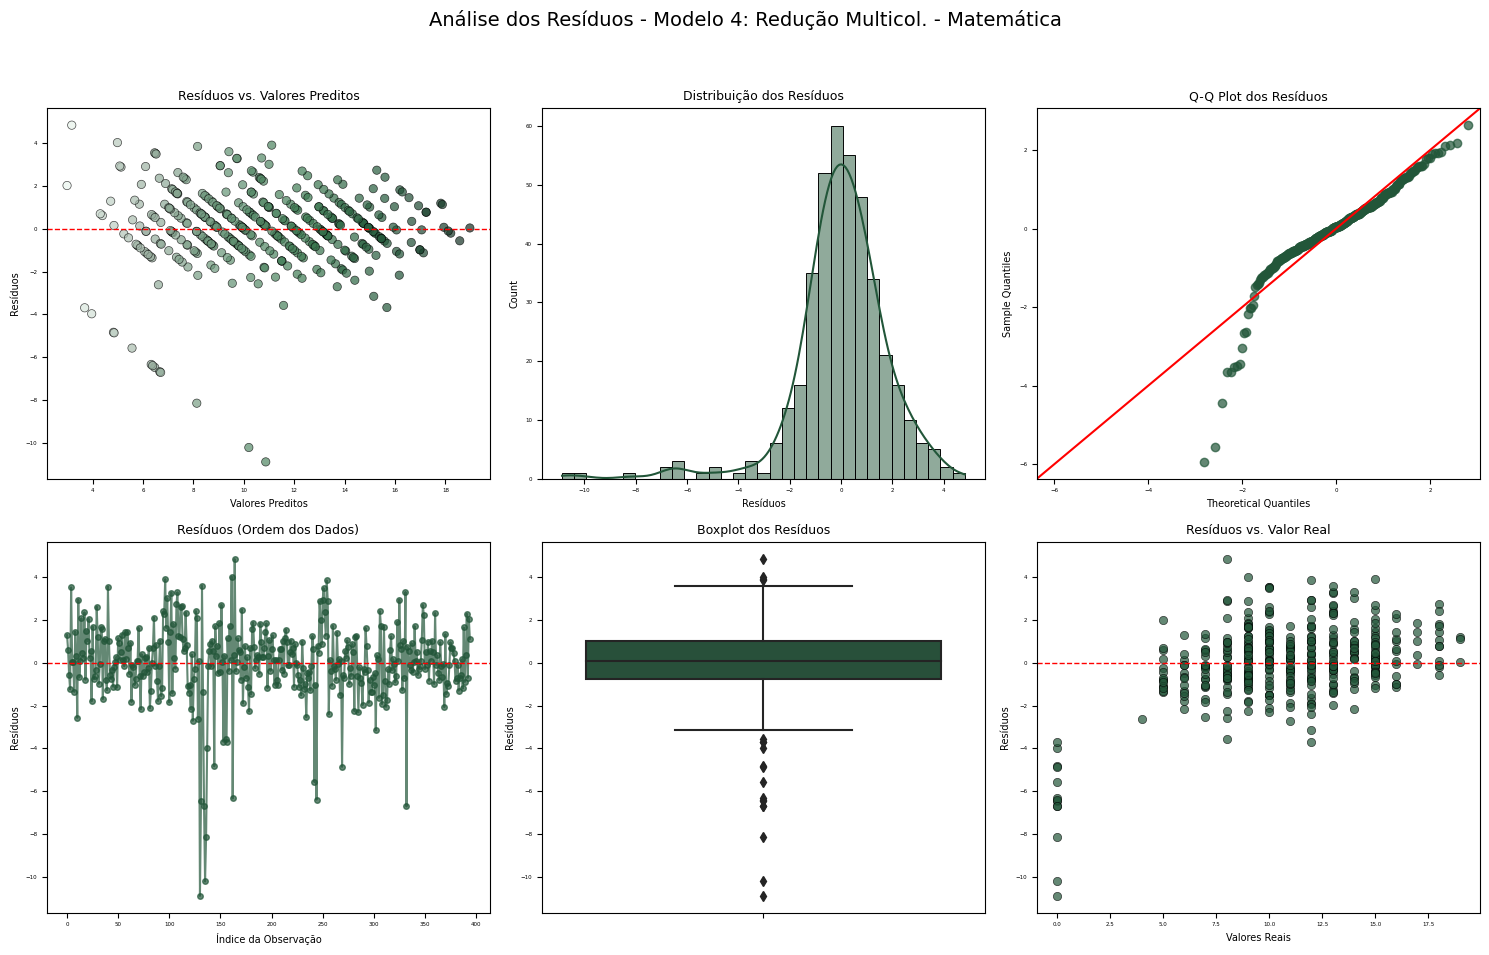

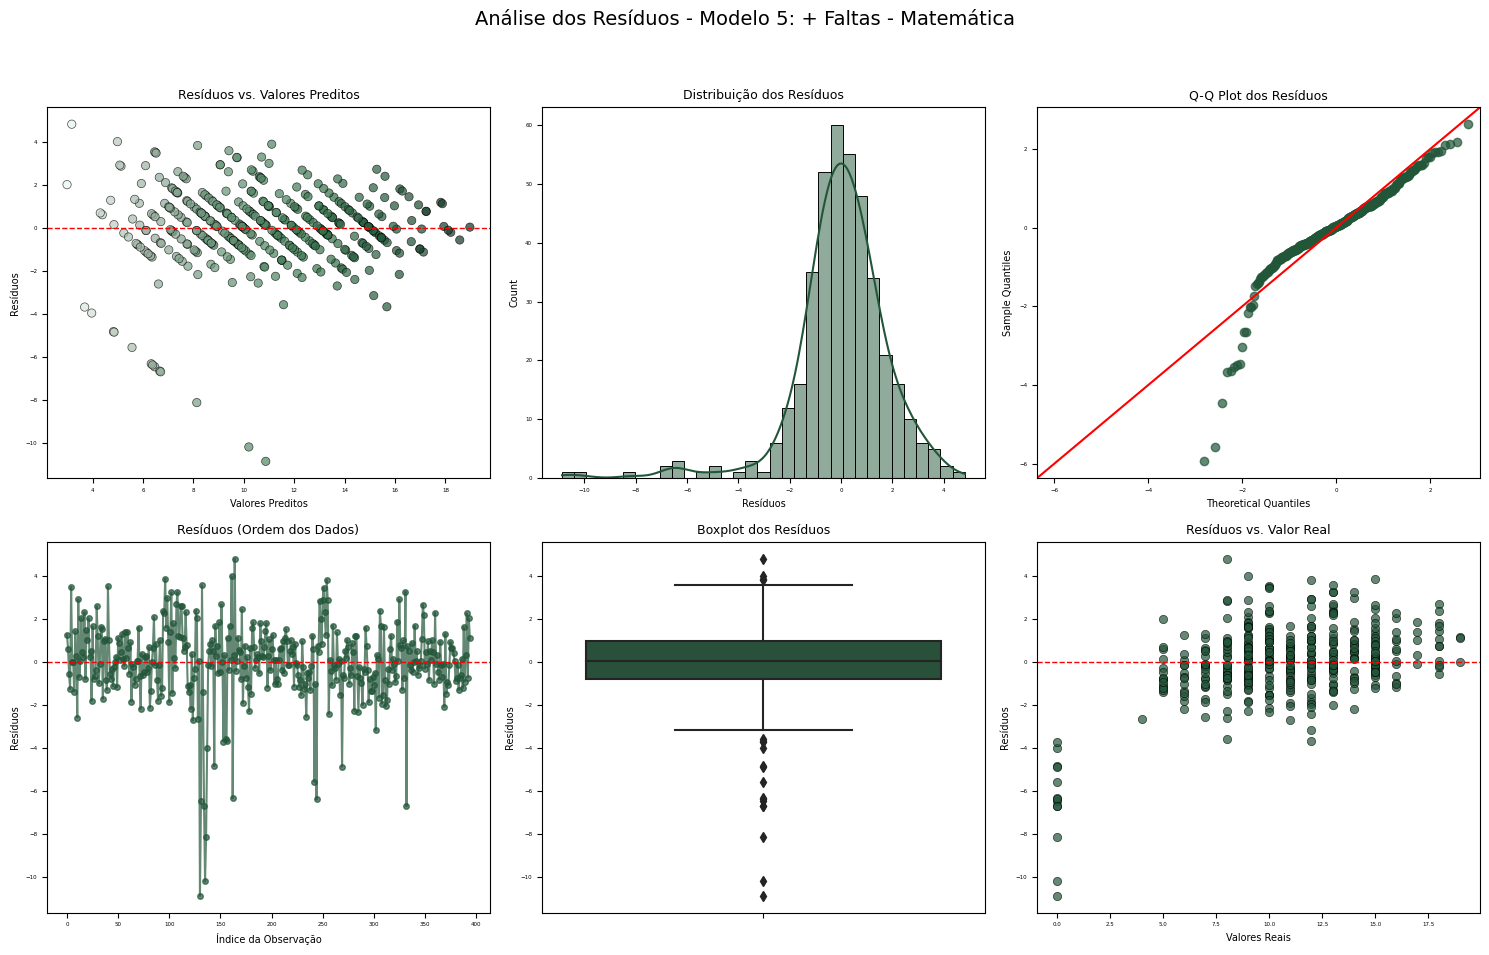

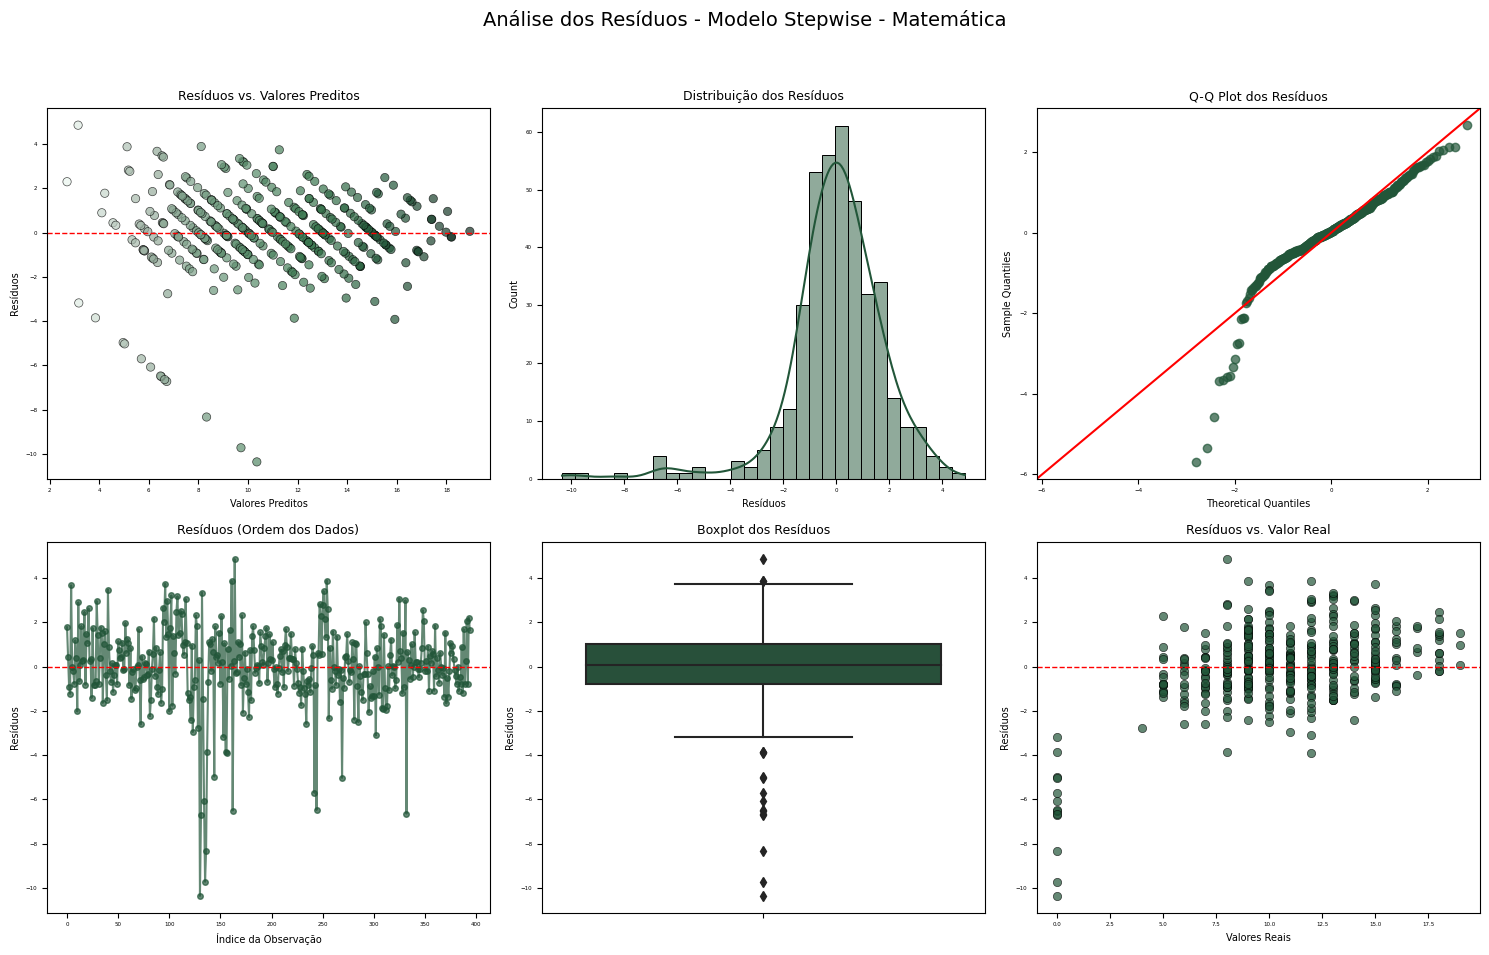

,Modelo,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,Modelo 1: Simples,0.0,0.8437,0.0,Não,0.0158,Não,1.4221,Presente (possível),10
1,Modelo 2: + Não-Notas,0.0,0.9014,0.0,Não,0.0001,Não,1.6123,Ausente (aprox.),9
2,Modelo 3: p-valores,-0.0,0.8890,0.0,Não,0.0004,Não,1.6024,Ausente (aprox.),9
3,Modelo 4: Redução Multicol.,-0.0,0.8815,0.0,Não,0.0010,Não,1.5786,Ausente (aprox.),9
4,Modelo 5: + Faltas,-0.0,0.8815,0.0,Não,0.0010,Não,1.5786,Ausente (aprox.),9
5,Modelo Stepwise,-0.0,0.8874,0.0,Não,0.0004,Não,1.5996,Ausente (aprox.),9


In [88]:
resultados_residuos = []

resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_1.predict(), 'Modelo 1: Simples', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_2.predict(), 'Modelo 2: + Não-Notas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_3.predict(), 'Modelo 3: p-valores', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_4.predict(), 'Modelo 4: Redução Multicol.', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_5.predict(), 'Modelo 5: + Faltas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_step.predict(), 'Modelo Stepwise', materia))

df_residuos = pd.DataFrame(resultados_residuos)
df_residuos

## 4.4 Importância com SHAP (Random Forest Regressor)


In [89]:
y = df_pp['nota2']
X = df_pp.drop(columns=['nota2'])


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Text(0.5, 1.0, 'Importância das variáveis - Treinamento')

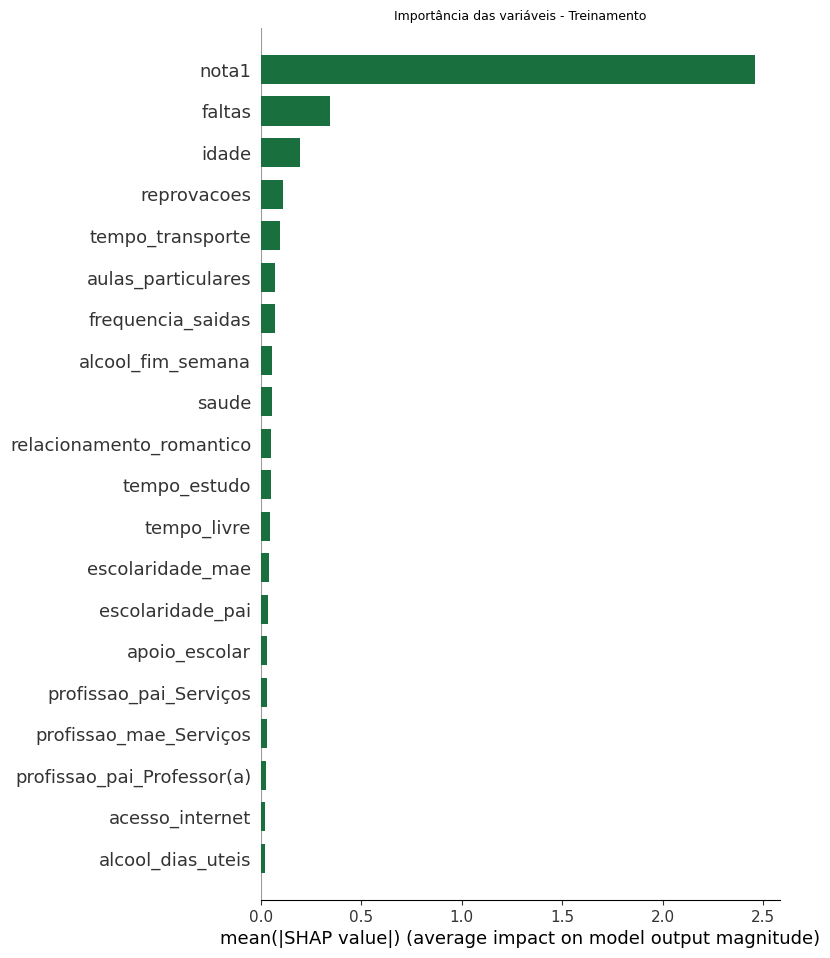

In [92]:
#Calcular os explainer -
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar", show=False,color='#196F3D')
plt.title('Importância das variáveis - Treinamento')

# 5. Análise dos Fatores Associados à Nota Final

- Objetivo: Investigar a contribuição de fatores socioeconômicos e escolares na nota final.

In [93]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final') 

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Shape final do DataFrame preparado: (395, 40)


## 5.4 Importância com SHAP (Random Forest Regressor)

Nesta etapa, utilizamos o SHAP (SHapley Additive Explanations) com um modelo Random Forest Regressor para identificar as variáveis com maior impacto na previsão da nota final.
A análise é realizada sobre o conjunto de treino, com foco em interpretar o que o modelo aprendeu sobre os fatores determinantes do desempenho geral dos alunos.


In [94]:
y = df_pp['nota_final']
X = df_pp.drop(columns=['nota_final'])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Text(0.5, 1.0, 'Importância das variáveis - Treinamento - Matemática')

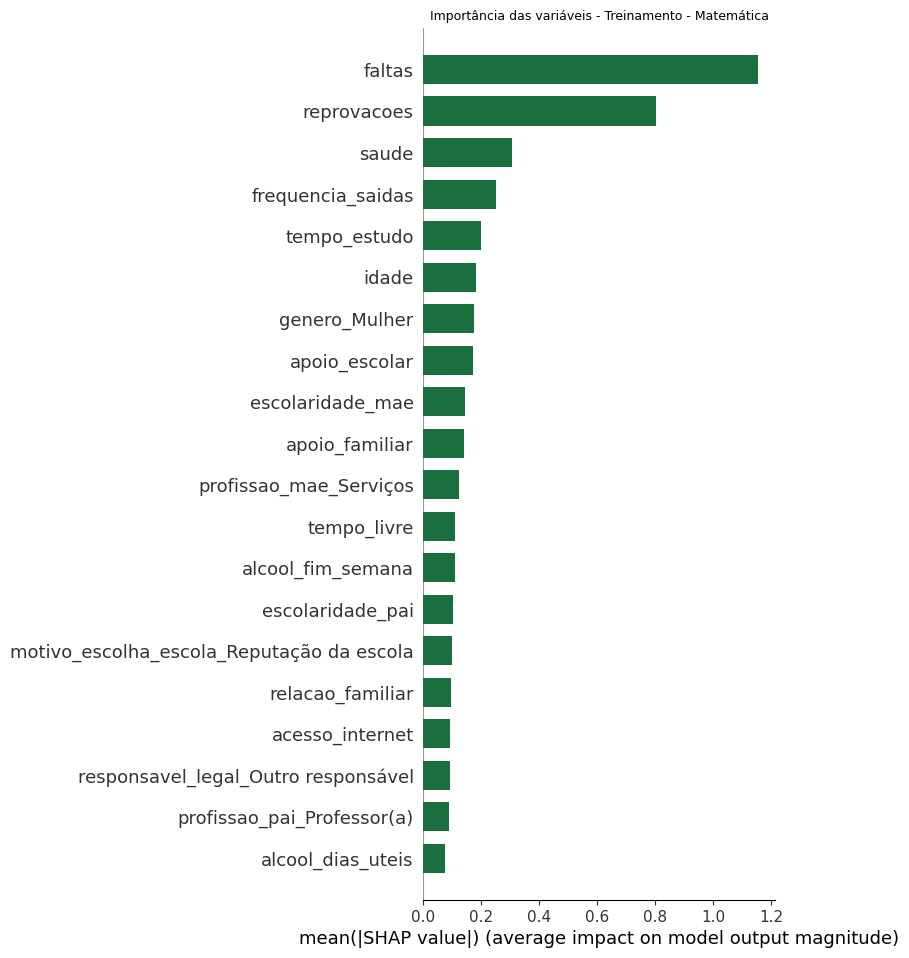

In [97]:
#Calcular os explainer -
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar",show=False, color='#196F3D')
plt.title('Importância das variáveis - Treinamento - Matemática')


# 6. Testes estatísticos para seleção de atributos

In [98]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


## 6.1. Testes para variáveis ordinais
- Aplicação de testes não paramétricos para avaliar associação com desempenho.

In [99]:
print('Matemática - Variáveis Categóricas Ordinais \n')
df_ord = selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Matemática - Variáveis Categóricas Ordinais 

Variáveis ordinais relevantes para explicabilidade do atributo 'nota_final'
  com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.361,1.28e-13,53.115,1.73e-11
0,escolaridade_mae,0.225,6.29e-06,24.104,7.61e-05
1,escolaridade_pai,0.170,0.001,14.677,0.005
4,frequencia_saidas,-0.166,0.001,14.697,0.005
8,alcool_dias_uteis,-0.121,0.016,7.475,0.113
7,tempo_transporte,-0.121,0.017,6.137,0.105
6,tempo_estudo,0.105,0.037,7.579,0.056
9,alcool_fim_semana,-0.104,0.038,5.453,0.244



## 6.2. Testes para variáveis nominais
- Aplicação de testes de independência para verificar significância de categorias nominais.

### 6.2.1 Aplicação nas variáveis nominais antes do onehotencoding

In [100]:
print('Português - Variáveis Categóricas Nominais \n')

df_nom =selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0)

Português - Variáveis Categóricas Nominais 

Variáveis com P-Value < 0.05 e V de Cramér > 0.00:


,Variable,P-Value,V de Cramér
2,reprovacoes,1.47e-10,0.351
1,frequencia_saidas,0.003,0.200
0,interesse_ensino_superior,0.004,0.145


### 6.2.1 Aplicação nas variáveis nominais após do onehotencoding

In [101]:
df_p = preparar_dados(df,'aprovacao',columns_to_drop=['nota1','nota2','nota_final'])

Removendo colunas: ['nota1', 'nota2', 'nota_final']
Shape final do DataFrame preparado: (395, 40)


In [102]:
v_c = pd.get_dummies(
    df[list(set(variaveis_categoricas_nominais) - {'aprovacao'})],
    drop_first=False
).columns.tolist()


variaveis_dummies_nominais = [col for col in df_p.columns if col in v_c]


In [103]:
variaveis_dummies_nominais

['escola_Mousinho da Silveira',
 'genero_Mulher',
 'endereco_Urbano',
 'status_parental_Separados',
 'profissao_mae_Outra profissão',
 'profissao_mae_Professor(a)',
 'profissao_mae_Serviços',
 'profissao_mae_Área da saúde',
 'profissao_pai_Outra profissão',
 'profissao_pai_Professor(a)',
 'profissao_pai_Serviços',
 'profissao_pai_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'motivo_escolha_escola_Próximo de casa',
 'motivo_escolha_escola_Reputação da escola',
 'responsavel_legal_Outro responsável',
 'responsavel_legal_Pai']

In [104]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# 1. Seleção das variáveis categóricas binárias (sem vírgula!)
X_cat_bin_only = df_p[variaveis_dummies_nominais]

# 2. Aplicar SelectKBest com chi2
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_cat_bin_only, y=df_p['aprovacao'])

# 3. Obter resultados
scores = selector_chi2.scores_
p_values = selector_chi2.pvalues_

chi2_results = pd.DataFrame({
    'Feature': X_cat_bin_only.columns,
    'Chi2_Score': scores,
    'P_Value': p_values
}).sort_values(by='P_Value', ascending=True)

# 4. Mostrar resultados
print('Português - Variáveis Categóricas Nominais (Dummies)\n')
print("\nResultados do Teste Qui-Quadrado (ordenado por P-Valor):")
display(chi2_results)

# 5. Selecionar features significativas
alpha = 0.05
significant_features_chi2 = chi2_results[chi2_results['P_Value'] < alpha]['Feature'].tolist()

print(f"\nFeatures categóricas/binárias com P-Valor < {alpha} (consideradas significativas):")
print(significant_features_chi2)





Português - Variáveis Categóricas Nominais (Dummies)


Resultados do Teste Qui-Quadrado (ordenado por P-Valor):


,Feature,Chi2_Score,P_Value
15,responsavel_legal_Outro responsável,4.232221,0.039664
7,profissao_mae_Área da saúde,2.338449,0.126215
4,profissao_mae_Outra profissão,1.397034,0.237221
14,motivo_escolha_escola_Reputação da escola,1.331958,0.248457
16,responsavel_legal_Pai,1.074222,0.299994
6,profissao_mae_Serviços,1.055202,0.304312
12,motivo_escolha_escola_Outro motivo,1.020501,0.312400
9,profissao_pai_Professor(a),1.010985,0.314667
1,genero_Mulher,0.932542,0.334203
3,status_parental_Separados,0.686909,0.407218



Features categóricas/binárias com P-Valor < 0.05 (consideradas significativas):
['responsavel_legal_Outro responsável']


## 6.3 Ordenamento por relevância estatística - Variáveis categóricas.

In [105]:
print(type(df_ord))

<class 'pandas.core.frame.DataFrame'>


In [106]:
print(type(df_nom))

<class 'tuple'>


In [107]:
# ou ajuste para o índice correto 
df_nom = df_nom[0].rename(columns={'Variable': 'Variável'}) #ajuste o nome da coluna conforme necessário



In [108]:
df_ord['P-valor (Spearman)'] = df_ord['P-valor (Spearman)'].astype(float)
df_ord['P-valor (Kruskal)'] = df_ord['P-valor (Kruskal)'].astype(float)
df_ord['Correlação (Spearman)'] = df_ord['Correlação (Spearman)'].astype(float)

df_nom['P-Value'] = df_nom['P-Value'].astype(float)
df_nom['V de Cramér'] = df_nom['V de Cramér'].astype(float)

In [109]:
# Critérios de relevância

# Ordinais: Spearman e Kruskal
df_ord['Relevante'] = (
    ((df_ord['P-valor (Spearman)'].astype('float') < 0.05) | 
     (df_ord['P-valor (Kruskal)'].astype('float') < 0.05)) &
    (df_ord['Correlação (Spearman)'].astype('float').abs() >= 0.15)
)

# Nominais: Qui-quadrado + V de Cramer
df_nom['Relevante'] = (
    (df_nom['P-Value'].astype('float') < 0.05) & 
    (df_nom['V de Cramér'].astype('float') >= 0.10)
)

In [110]:
# ORDINAIS
df_ord['Tipo'] = 'Ordinal'
df_ord['Força de Associação'] = df_ord['Correlação (Spearman)'].abs()
df_ord_rank = df_ord[df_ord['Relevante']][['Variável', 'Tipo', 'Força de Associação']]

# NOMINAIS
df_nom['Tipo'] = 'Nominal'
df_nom['Força de Associação'] = df_nom['V de Cramér']
df_nominais_rank = df_nom[df_nom['Relevante']][['Variável', 'Tipo', 'Força de Associação']]

# RANKEAMENTO FINAL 
df_rank_unico = pd.concat([df_ord_rank, df_nominais_rank], ignore_index=True)
df_rank_unico = df_rank_unico.sort_values(by='Força de Associação', ascending=False).reset_index(drop=True)
df_rank_unico['Tipo'] = df_rank_unico['Variável'].apply(
    lambda var: 'Ordinal' if var in variaveis_categoricas_ordinais
    else 'Nominal' if var in variaveis_categoricas_nominais
    else 'Outro'
)



In [111]:
df_rank_deduplicado = df_rank_unico.sort_values(by='Força de Associação', ascending=False) \
                                    .drop_duplicates(subset='Variável', keep='first') \
                                    .reset_index(drop=True)


In [112]:
df_rank_deduplicado

,Variável,Tipo,Força de Associação
0,reprovacoes,Ordinal,0.361
1,escolaridade_mae,Ordinal,0.225
2,frequencia_saidas,Ordinal,0.200
3,escolaridade_pai,Ordinal,0.170
4,interesse_ensino_superior,Nominal,0.145


In [113]:
lista_final = df_rank_deduplicado['Variável'].tolist()

In [114]:
lista_final 

['reprovacoes',
 'escolaridade_mae',
 'frequencia_saidas',
 'escolaridade_pai',
 'interesse_ensino_superior']

# 7. Análise exploratória multivariada (PCA e Clusterização)

Objetivo: Verificar se há perfis de alunos com características semelhantes com base nas variáveis selecionadas, por meio de técnicas de redução de dimensionalidade (PCA) e clusterização (KMeans).

In [115]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final')

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Shape final do DataFrame preparado: (395, 40)


In [116]:

# Seleção dos dados 
X = df_pp.drop(columns=['nota_final'])
y = df_pp['nota_final']
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


### Definindo o número de clusters

In [117]:
from sklearn.metrics import silhouette_score

In [118]:
k_values = list(range(2, 9))
inercia = []
silhouette = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inercia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

# Cálculo da redução percentual da inércia
reducoes = np.diff(inercia) / inercia[:-1]
limiar = 0.15 #redução mínima esperada

# Determina melhor k pelo método do cotovelo
melhor_k_cotovelo = None
for k_idx, r in enumerate(reducoes, start=2):
    if abs(r) * 100 < limiar * 100 and melhor_k_cotovelo is None:
        melhor_k_cotovelo = k_idx
if melhor_k_cotovelo is None:
    melhor_k_cotovelo = k_values[-1]

# Melhor k pelo índice de silhueta
melhor_k_silhueta = k_values[np.argmax(silhouette)]


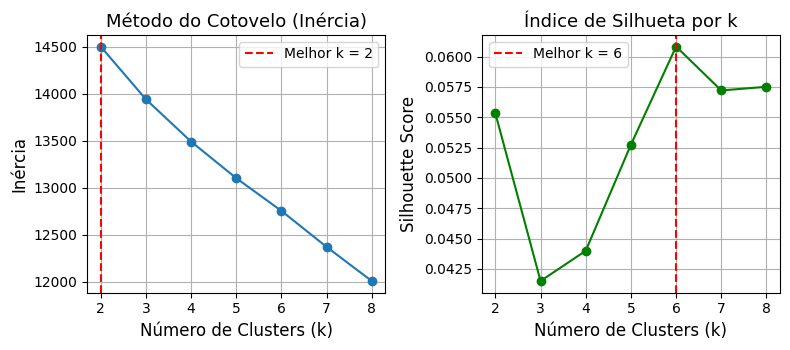

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.6))

# Tamanho da fonte
fs_ticks = 10
fs_labels = 12
fs_title = 13

# Cotovelo
axs[0].plot(k_values, inercia, marker='o')
axs[0].axvline(x=melhor_k_cotovelo, color='red', linestyle='--', label=f'Melhor k = {melhor_k_cotovelo}')
axs[0].set_title('Método do Cotovelo (Inércia)', fontsize=fs_title)
axs[0].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[0].set_ylabel('Inércia', fontsize=fs_labels)
axs[0].legend(fontsize=fs_ticks)
axs[0].set_xticks(k_values)
axs[0].tick_params(axis='both', labelsize=fs_ticks)
axs[0].grid(True)

# Silhueta
axs[1].plot(k_values, silhouette, marker='o', color='green')
axs[1].axvline(x=melhor_k_silhueta, color='red', linestyle='--', label=f'Melhor k = {melhor_k_silhueta}')
axs[1].set_title('Índice de Silhueta por k', fontsize=fs_title)
axs[1].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[1].set_ylabel('Silhouette Score', fontsize=fs_labels)
axs[1].legend(fontsize=fs_ticks)
axs[1].set_xticks(k_values)
axs[1].tick_params(axis='both', labelsize=fs_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [120]:
# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [121]:
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


#### Influência de Variáveis sobre o PCA

In [122]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['Componente 1', 'Componente 2'],
    index=X.columns)

loadings['Magnitude'] = loadings.apply(lambda x: np.sqrt(x['Componente 1']**2 + x['Componente 2']**2), axis=1)
loadings = loadings.sort_values(by='Magnitude', ascending=False)
loadings = loadings[loadings['Magnitude'] > 0.1]        
loadings = loadings.reset_index()
loadings.columns = ['Variável', 'Componente 1', 'Componente 2', 'Magnitude']
loadings

,Variável,Componente 1,Componente 2,Magnitude
0,escolaridade_mae,-0.353709,0.232328,0.423186
1,alcool_dias_uteis,0.176966,0.378820,0.418117
2,alcool_fim_semana,0.200054,0.366197,0.417279
3,escolaridade_pai,-0.333011,0.226621,0.402807
4,profissao_mae_Professor(a),-0.203897,0.236436,0.312211
5,genero_Mulher,-0.093383,-0.292520,0.307064
6,profissao_mae_Outra profissão,0.179804,-0.238704,0.298847
7,profissao_pai_Outra profissão,0.146971,-0.251724,0.291488
8,tempo_estudo,-0.169922,-0.229865,0.285852
9,reprovacoes,0.262712,0.072241,0.272463


In [123]:
cores = aplicar_estilo_visual(paleta=cor_paleta,n =10)[::-1]

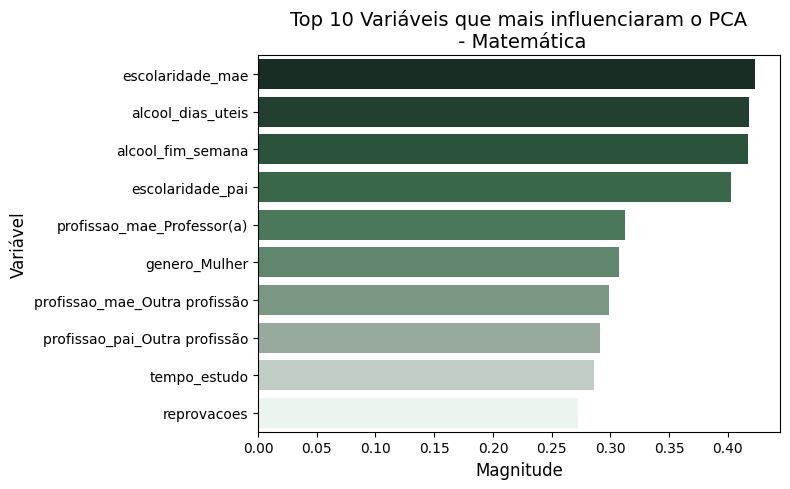

In [124]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Magnitude', y='Variável', data=top_loadings, palette=cores)

plt.title('Top 10 Variáveis que mais influenciaram o PCA\n - Matemática', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Variável', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


#### **k=2**

In [125]:
df['cluster_k2'] = KMeans(n_clusters=melhor_k_cotovelo, random_state=42).fit_predict(X_pca)

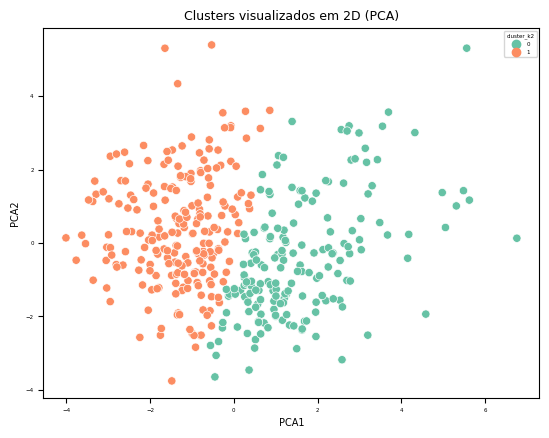

In [126]:
df['cluster_k2'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# 5. Visualiza os clusters  
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k2', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


In [127]:
df.groupby('cluster_k2')[['nota_final', 'faltas']].describe()


nota_final                                                  faltas  \
                count       mean       std  min  25%   50%   75%   max  count   
cluster_k2                                                                      
0               179.0   9.223464  4.654985  0.0  7.5  10.0  12.0  19.0  179.0   
1               216.0  11.402778  4.285160  0.0  9.0  11.0  14.0  20.0  216.0   

                                                          
                mean       std  min  25%  50%  75%   max  
cluster_k2                                                
0           5.715084  8.441627  0.0  0.0  3.0  8.0  75.0  
1           5.703704  7.640479  0.0  0.0  4.0  8.0  56.0

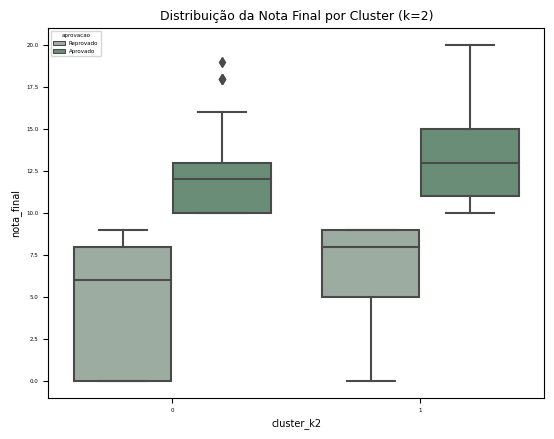

In [128]:
cor_paleta = aplicar_estilo_visual('verde')

# Gráfico de dispersão
sns.boxplot(data=df, x='cluster_k2', y='nota_final', hue='aprovacao',palette=cor_paleta)
plt.title('Distribuição da Nota Final por Cluster (k=2)')
plt.show()


#### **k=8**

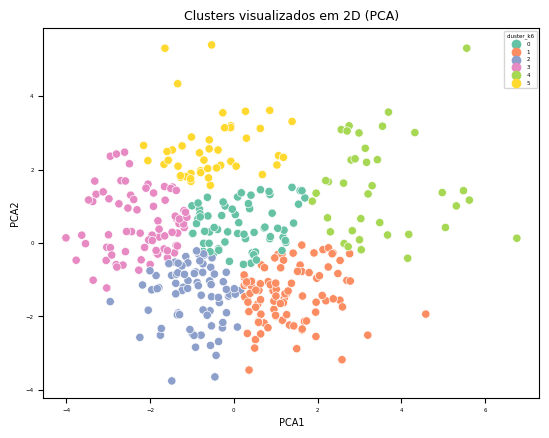

In [129]:

df['cluster_k6'] = KMeans(n_clusters=melhor_k_silhueta, random_state=42).fit_predict(X_pca)
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k6', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


In [130]:
df.groupby('cluster_k6')[['nota_final', 'faltas']].describe()


nota_final                                                     \
                count       mean       std  min   25%   50%    75%   max   
cluster_k6                                                                 
0                66.0   9.924242  4.538080  0.0   8.0  11.0  13.00  19.0   
1                93.0   9.935484  4.822516  0.0   8.0  11.0  13.00  19.0   
2                79.0  10.455696  4.590395  0.0   8.5  11.0  13.50  19.0   
3                74.0  12.621622  4.060173  0.0  10.0  14.0  15.00  20.0   
4                38.0   8.078947  4.474441  0.0   7.0   9.0  10.75  16.0   
5                45.0  10.400000  3.689050  0.0   9.0  10.0  12.00  18.0   

           faltas                                                    
            count      mean        std  min   25%  50%    75%   max  
cluster_k6                                                           
0            66.0  6.712121  10.182587  0.0  1.25  3.0   8.75  56.0  
1            93.0  6.451613  10.279270  0.0  0.00  2.0  10.00  75.0  
2            79.0  4.493671   4.916934  0.0  0.00  4.0   6.50  26.0  
3            74.0  3.635135   4.446252  0.0  0.00  2.0   6.00  23.0  
4            38.0  4.368421   4.528714  0.0  0.00  4.0   6.00  16.0  
5            45.0  9.377778   8.868455  0.0  4.00  7.0  14.00  38.0

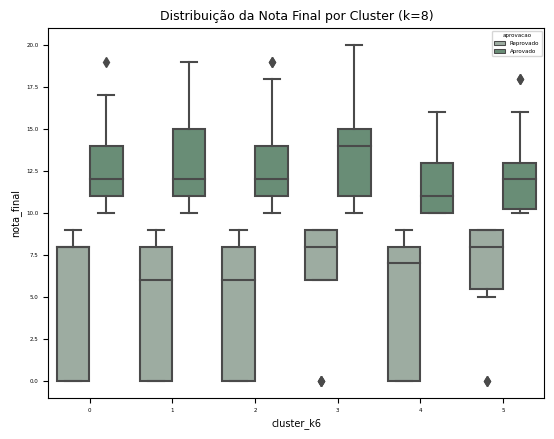

In [131]:
sns.boxplot(data=df, x='cluster_k6', y='nota_final', hue='aprovacao',palette=cor_paleta)
plt.title('Distribuição da Nota Final por Cluster (k=8)')
plt.show()